# ROI selector

In [ ]:
%matplotlib widget
import numpy as np
import panel as pn
import matplotlib.pyplot as plt
import io

pn.extension()

class ROISelector:
    def __init__(self, image: np.ndarray):
        self.image = image
        h, w = image.shape[:2]

        self.x = pn.widgets.IntSlider(name="X", start=0, end=w-1, value=w//4)
        self.y = pn.widgets.IntSlider(name="Y", start=0, end=h-1, value=h//4)
        self.width = pn.widgets.IntSlider(name="Width", start=1, end=w, value=w//2)
        self.height = pn.widgets.IntSlider(name="Height", start=1, end=h, value=h//2)

        self._plot = pn.bind(self._plot_roi, self.x, self.y, self.width, self.height)

        self.panel = pn.Column(
            pn.Row(self.x, self.y),
            pn.Row(self.width, self.height),
            self._plot
        )

    def _plot_roi(self, x, y, width, height):
        x_end = min(x + width, self.image.shape[1])
        y_end = min(y + height, self.image.shape[0])
        cropped = self.image[y:y_end, x:x_end]

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        ax = [ax]
        ax[0].imshow(self.image, cmap='gray')
        ax[0].add_patch(plt.Rectangle((x, y), width, height, edgecolor='red', facecolor='none'))
        ax[0].set_title("Image with ROI")
        # ax[1].imshow(cropped, cmap='gray')
        # ax[1].set_title("Cropped ROI")

        buf = io.BytesIO()
        plt.tight_layout()
        plt.savefig(buf, format="png")
        plt.close(fig)
        
        return pn.pane.PNG(buf.getvalue(), width=800)

    def view(self):
        return self.panel

    def get_roi(self):
        x, y = self.x.value, self.y.value
        x_end = min(x + self.width.value, self.image.shape[1])
        y_end = min(y + self.height.value, self.image.shape[0])
        return self.image[y:y_end, x:x_end]

    def get_roi_coords(self):
        x, y = self.x.value, self.y.value
        x_end = min(x + self.width.value, self.image.shape[1])
        y_end = min(y + self.height.value, self.image.shape[0])

        return np.array([x,y,x_end,y_end])
        
    def get_roi_xywh(self) :
        return np.array([self.x.value, self.y.value,self.width.value, self.height.value])
        

Column
    [0] Row
        [0] IntSlider(end=299, name='X', value=75)
        [1] IntSlider(end=199, name='Y', value=50)
    [1] Row
        [0] IntSlider(end=300, name='Width', start=1, value=150)
        [1] IntSlider(end=200, name='Height', start=1, value=100)
    [2] ParamFunction(function, _pane=PNG, defer_load=False)
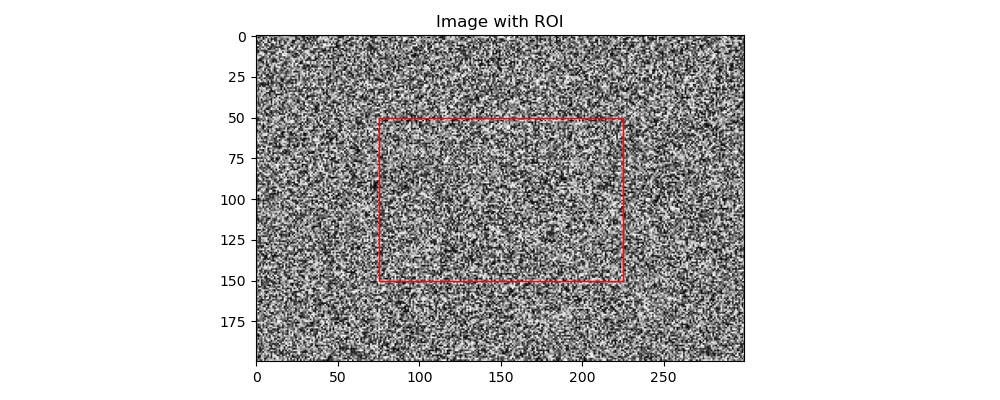

In [3]:
# Generate dummy image
img = np.random.rand(200, 300)

# Create ROI selector
roi_tool = ROISelector(img)

# Show UI
roi_tool.view()


In [4]:
roi_array = roi_tool.get_roi_coords()
roi_array

array([ 75,  50, 225, 150])

# File chooser

In [ ]:
import panel as pn
from pathlib import Path
pn.extension()

class FlexibleFileSelector:
    def __init__(self,path="~"):
        self.mode = pn.widgets.RadioButtonGroup(
            name="Input Mode",
            options=["Single File", "File List", "Pattern + Range"],
            button_type='primary'
        )

        # Mode 1: Single file
        self.single_file = pn.widgets.TextInput(name="File Path")
        self.single_browse = pn.widgets.FileSelector(name="Browse File",directory=path,file_pattern='*')
        self.single_browse.param.watch(self._sync_single_file, "value")

        # Mode 2: List of files (via text or directory select)
        self.file_list = pn.widgets.TextAreaInput(name="File List (one per line)")
        self.list_browse = pn.widgets.FileSelector(name="Browse Directory")
        self.list_browse.param.watch(self._sync_file_list, "value")

        # Mode 3: Pattern + Range
        self.pattern = pn.widgets.TextInput(name="Pattern", placeholder="e.g. image_{:04d}.tif")
        self.start = pn.widgets.IntInput(name="Start Index", value=0)
        self.end = pn.widgets.IntInput(name="End Index", value=10)

        # Dynamic view
        self.mode_panel = pn.bind(self._update_view, self.mode)

        # Output display
        self.output = pn.pane.Markdown()

        # Resolve button
        self.button = pn.widgets.Button(name="Resolve Files", button_type="success")
        self.button.on_click(self._on_resolve)

        self.panel = pn.Column(
            pn.pane.Markdown("### Flexible File Selector"),
            self.mode,
            self.mode_panel,
            self.button,
            self.output
        )

    def _sync_single_file(self, event):
        self.single_file.value = str(event.new)

    def _sync_file_list(self, event):
        self.file_list.value = "\n".join(str(f) for f in event.new)

    def _update_view(self, mode):
        if mode == "Single File":
            return pn.Column(self.single_file, self.single_browse)
        elif mode == "File List":
            return pn.Column(self.file_list, self.list_browse)
        elif mode == "Pattern + Range":
            return pn.Column(self.pattern, pn.Row(self.start, self.end))
        return pn.pane.Markdown("Unknown mode")

    def _on_resolve(self, _):
        files = self.get_file_list()
        self.output.object = f"**Resolved {len(files)} files:**\n" + "\n".join(str(f) for f in files[:10])
        if len(files) > 10:
            self.output.object += "\n..."

    def get_file_list(self):
        mode = self.mode.value
        if mode == "Single File":
            return [self.single_file.value.strip()]
        elif mode == "File List":
            return [line.strip() for line in self.file_list.value.strip().splitlines() if line.strip()]
        elif mode == "Pattern + Range":
            pat = self.pattern.value.strip()
            return [pat.format(i) for i in range(self.start.value, self.end.value + 1)]
        return []

    def view(self):
        return self.panel


In [49]:
selector = FlexibleFileSelector()
selector.view()

Column
    [0] Markdown(str)
    [1] RadioButtonGroup(button_type='primary', name='Input Mode', options=['Single File', ...], value='Single File')
    [2] ParamFunction(function, _pane=Column, defer_load=False)
    [3] Button(button_type='success', name='Resolve Files')
    [4] Markdown(None)

In [ ]:
files = selector.get_file_list()
print(files)

## New version

In [ ]:
import panel as pn
import re
from pathlib import Path

pn.extension()

class SingleFileMaskSelector:
    def __init__(self, path="."):
        self.file_selector = pn.widgets.FileSelector(name="Select File", directory=path)
        self.button = pn.widgets.Button(name="Resolve", button_type="primary")
        self.output = pn.pane.Markdown()
        self._info = {}

        self.button.on_click(self._on_resolve)

        self.panel = pn.Column(
            pn.pane.Markdown("### Select a File to Extract Pattern Info"),
            self.file_selector,
            self.button,
            self.output
        )

    def _on_resolve(self, event=None):
        file_path = self.file_selector.value
        
        if not file_path:
            self.output.object = "**No file selected.**"
            return

        path = Path(file_path)
        filename = path.name

        # Try to extract the numeric index
        match = re.search(r"(\d+)", filename)
        if match:
            index = int(match.group(1))
            start, end = index, index
            span = match.span()
            prefix = filename[:span[0]]
            suffix = filename[span[1]:]
            width = len(match.group(1))
            file_mask = f"{prefix}{{:0{width}d}}{suffix}"
        else:
            file_mask = filename
            start = end = 0

        # Update info dict
        self._info = {
            "file_name": filename,
            "file_mask": file_mask,
            "first": start,
            "last": end,
        }

        # Display
        self.output.object = f"""**Resolved Information**
- **File Name**: `{filename}`
- **File Mask**: `{file_mask}`
- **First Index**: `{start}`
- **Last Index**: `{end}`"""

    def get_info(self):
        return self._info

    def view(self):
        return self.panel


In [47]:
selector = SingleFileMaskSelector(path="/Users/kaestner/git/TestData")
selector.view()


Column
    [0] Markdown(str)
    [1] FileSelector(directory='/Users/kaestner/git/TestD..., name='Select File')
    [2] Button(button_type='primary', name='Resolve')
    [3] Markdown(None)

In [ ]:
info = selector.get_info()
print(info)

{}


In [23]:
pn.extension()

fs = pn.widgets.FileSelector(directory="/Users/")
fs

FileSelector(directory='/Users')

In [39]:
fs.value

['/Users/kaestner/Downloads/1-s2.0-S2352409X24004292-main.pdf']

## Ipywidgets version

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import re
from pathlib import Path
from ipyfilechooser import FileChooser

class IpyFileMaskSelector:
    def __init__(self):
        self.file_path_input = widgets.Text(
            description="File Path:",
            placeholder="Type or use browse button"
        )

        self.file_upload = widgets.FileUpload(
            description="Browse",
            multiple=False
        )
        self.file_upload.observe(self._on_upload, names="value")

        self.output = widgets.Output()

        self._info = {}

        # UI layout
        self.ui = widgets.VBox([
            widgets.HTML("<b>Select a file to infer pattern info</b>"),
            widgets.HBox([self.file_path_input, self.file_upload]),
            self.output
        ])

    def _on_upload(self, change):
        # Uploaded file name, not full path
        if self.file_upload.value:
            name = self.file_upload.value[0]['name']
            self.file_path_input.value = name
            self.output.clear_output()
            filename = Path(self.file_path_input.value).name

            # Try to infer index
            match = re.search(r"(\d+)", filename)
            if match:
                index = int(match.group(1))
                start = end = index
                span = match.span()
                prefix = filename[:span[0]]
                suffix = filename[span[1]:]
                width = len(match.group(1))
                file_mask = f"{prefix}{{:0{width}d}}{suffix}"
            else:
                file_mask = filename
                start = end = 0

            self._info = {
                "file_name": filename,
                "file_mask": file_mask,
                "first": start,
                "last": end,
            }

            with self.output:
                print("Resolved Info:")
                for k, v in self._info.items():
                    print(f"  {k}: {v}")

    def get_info(self):
        return self._info

    def view(self):
        display(self.ui)

In [23]:
selector = IpyFileMaskSelector()
selector.view()

In [25]:
selector.file_upload.value

({'name': 'bbempty_1s_00003.fits',
  'type': '',
  'size': 8398080,
  'content': <memory at 0x15d5d2700>,
  'last_modified': datetime.datetime(2024, 10, 11, 6, 31, 32, tzinfo=datetime.timezone.utc)},)